In [1]:
#imports
import torch
from torch import nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import json
import glob
import time
from PIL import Image

In [2]:
from transformers import CLIPProcessor, CLIPModel

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

preprocess = processor.feature_extractor
tokenizer = processor.tokenizer

In [3]:
class MLP(nn.Module):
    def __init__(self, dense_size, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.linear = nn.Linear(dense_size, 1)
        self.linear.apply(self._init_weights)
        
    def _init_weights(self, module):
        torch.nn.init.kaiming_normal_(module.weight.data, nonlinearity="relu")
    
    def forward(self, last_hidden_states, input_ids, attention_mask):
        batch_size = last_hidden_states.shape[0]
        tok_weights = torch.log1p(torch.relu(self.linear(last_hidden_states))).squeeze(-1)*attention_mask
        lex_weights = torch.zeros(batch_size, self.vocab_size).to(device)
        columns = torch.arange(batch_size).repeat((77,1)).T
        lex_weights[columns, input_ids.type(torch.int64)] = tok_weights
        return lex_weights

In [4]:
class MLM(nn.Module):
    def __init__(self, dense_size, vocab_size):
        super().__init__()
        self.linear = nn.Linear(dense_size, vocab_size)
        
    def forward(self, dense_vec):
        term_importances = torch.log1p(torch.relu(self.linear(dense_vec)))
        return term_importances

In [5]:
def test_sparse_performance(MLP, MLM, test_ims, test_lhs, test_ids, test_att):
    with torch.no_grad():
        x, _ = test_ims.shape
        encoded_images = torch.empty(int(x/5), 49408)
        for i in range(0, len(test_ims), 5):
            encoded_images[int(i/5)] = MLM(test_ims[i])

        encoded_captions = torch.empty(int(x), 49408)
        for i in range(0, len(test_lhs), 64):
            encoded_captions[i:i+64] = MLP(test_lhs[i:i+64], test_ids[i:i+64], test_att[i:i+64])

        encoded_images = (encoded_images / encoded_images.norm(dim=-1, keepdim=True)).to(device)
        encoded_captions = encoded_captions / encoded_captions.norm(dim=-1, keepdim=True)

        recall_1 = []
        recall_5 = []
        recall_10 = []
        i = 0
        image_id = 0
        for text_feature in encoded_captions:
            similarity = (100.0 * text_feature.to(device) @ encoded_images.T).softmax(dim=-1)

            values, indices = similarity.topk(1)
            recall_1.append(image_id in indices)

            values, indices = similarity.topk(5)
            recall_5.append(image_id in indices)

            values, indices = similarity.topk(10)
            recall_10.append(image_id in indices)

            i += 1
            if i == 5:
                i = 0
                image_id += 1

        recall_1 = torch.Tensor(recall_1)
        recall_5 = torch.Tensor(recall_5)
        recall_10 = torch.Tensor(recall_10)
        return recall_1.mean(), recall_5.mean(), recall_10.mean()

In [6]:
class TrainBatches():
    def __init__(self, image_vectors, captions):

        self.images = image_vectors
        self.captions  = captions

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]
        return image,caption

In [7]:
#open the json file for annotations
f = open('datasets/flickr30k/dataset_flickr30k.json')
data = json.load(f)

# load all captions
caps = [x['sentences'] for x in data['images'] if x.get('split') == 'train']
test_caps = [x['sentences'] for x in data['images'] if x.get('split') == 'test']

files = []
test_files = []
for x in data['images']:
    if x.get('split') == 'train':
        files.append('datasets/flickr30k/train/' + x['filename'])
    
    elif x.get('split') == 'test':
        test_files.append('datasets/flickr30k/test/' + x['filename'])
            
captions = []
for x in caps:
    for y in x:
        captions.append(y)
        
test_captions = []
for x in test_caps:
    for y in x:
        test_captions.append(y)
    
captions = [x.get('raw') for x in captions]
test_captions = [x.get('raw') for x in test_captions]

# these captions are too long and need adjusting
captions[13035] = 'Four young adults sit outside on a wooden deck near a building around a small round table, while another person stands on the edge of the deck, leaning on the wooden railing, with the sun shining on one of them, one holding a cellphone out in front of himself and another holding a green and red soda can.'
captions[14580] = 'A man wearing a helmet, red pants with white and a white and red shirt is on a small bicycle using only his hands, while another man wearing a light blue shirt with dark blue trim and black pants with red stripes is standing nearby, gesturing toward the first man and holding a small figurine.'
captions[120165] = 'In this photo there is a man in a dirty white shirt and a black hat with yellow stained teeth, he looks happy and it appears that he is also repairing something.'
test_captions[3905] = 'Two boys are looking upwards with their arms streteched to the sky, the boy on the left is wearing a blue vest jacket with a gray shirt, black jogging pants and a hat, and the boy on the right is wearing a silver vest jacket, with blue long-sleeved undershirt, gray pants, black tennis shoes and has black short hair and glasses.'

In [8]:
files = files[0:1000]
captions = captions[0:5000]

In [8]:
# encode images
L = len(files)
batch_size = 128
t1 = time.time()
with torch.no_grad():
    encoded_ims = torch.Tensor()
    for i in range(0, L, batch_size):
        print(i,"/",L, end='\r')
        images = torch.Tensor().to(device)
        for x in range(batch_size):
            if (i + x) < L:
                image = preprocess(Image.open(files[i+x]), return_tensors='pt')['pixel_values'].to(device)
                images = torch.cat((images, image), 0)
                
        ims = model.vision_model(images).pooler_output
        ims = model.visual_projection(ims)
        encoded_ims = torch.cat((encoded_ims, ims.to("cpu")), 0)

p = 0
encoded_images = torch.Tensor().to(device)
for image in encoded_ims:
    if (p%100) == 0:
        print(p,"/",L, end='\r')
        
    encoded_images = torch.cat((encoded_images, image.to(device).repeat(5,1)), 0)
    p += 1
    
print("")
print("done")
print(time.time() - t1)

28900 / 29000 / 29000 / 29000
done
253.38529133796692


In [9]:
# encode captions
L = len(captions)
t1 = time.time()
with torch.no_grad():
    tokenized_captions = []
    for i in range(0, L):
        if (i%1000) == 0:
            print(i,"/",L, end='\r')
        text = tokenizer(captions[i], padding='max_length', max_length=77, return_tensors='pt').to(device)
        tokenized_captions.append(text)
        
print("")
print("done")
print(time.time() - t1)

144000 / 145000 145000 / 145000 / 145000 / 145000 145000 / 145000 145000 145000 / 145000 145000 145000 145000 / 145000 / 145000 / 145000 / 145000 / 145000 145000 145000 / 145000 145000 145000
done
29.970247268676758


In [10]:
# encode test images
L = len(test_files)
batch_size = 256
with torch.no_grad():
    test_ims = torch.Tensor().to(device)
    for i in range(0, L, batch_size):
        print(i,"/",L, end='\r')
        images = torch.Tensor().to(device)
        for x in range(batch_size):
            if (i + x) < L:
                image = preprocess(Image.open(test_files[i+x]), return_tensors='pt')['pixel_values'].to(device)
                images = torch.cat((images, image), 0)
                
        ims = model.vision_model(images).pooler_output
        ims = model.visual_projection(ims)
        test_ims = torch.cat((test_ims, ims), 0)

test_images = torch.Tensor().to(device)
for image in test_ims:
    test_images = images = torch.cat((test_images, image.repeat(5,1)), 0)
    
print("")
print("done")

768 / 1000
done


In [11]:
# encode test captions
L = len(test_captions)
batch_size = 128
with torch.no_grad():
    test_features = torch.Tensor().to(device)
    test_ids = torch.Tensor().to(device)
    test_masks = torch.Tensor().to(device)
    for i in range(0, L, batch_size):
        print(i,"/",L, end='\r')
        text = tokenizer(test_captions[i:i+batch_size], padding='max_length', max_length=77, return_tensors='pt').to(device)
        text_lhs = model.text_model(**text).last_hidden_state
        text_lhs = model.text_projection(text_lhs)
        
        test_features = torch.cat((test_features, text_lhs), 0)
        test_ids = torch.cat((test_ids, text.input_ids), 0)
        test_masks = torch.cat((test_masks, text.attention_mask), 0)
        
print("")
print("done")

4992 / 5000/ 5000 / 5000 / 5000 / 5000 5000 / 5000 / 5000
done


In [12]:
batchsize = 16

dataset = TrainBatches(encoded_images, tokenized_captions)
train_dataloader = DataLoader(dataset, batch_size = batchsize, shuffle=True)

In [21]:
dense_text_size = model.text_projection.weight.shape[0]
dense_image_size = model.visual_projection.weight.shape[0]
vocab_size = model.text_model.config.vocab_size

text_encoder = MLP(dense_text_size, vocab_size).to(device)
image_encoder = MLM(dense_image_size, vocab_size).to(device)

In [15]:
im_checkpoint = torch.load("Models/image_enc.pt", map_location='cpu')
text_checkpoint = torch.load("Models/text_enc.pt", map_location='cpu')

image_encoder.load_state_dict(im_checkpoint['model_state_dict'])
text_encoder.load_state_dict(text_checkpoint['model_state_dict'])

<All keys matched successfully>

In [22]:
#before training
rec1,rec5,rec10 = test_sparse_performance(text_encoder, image_encoder, test_images, test_features, test_ids, test_masks)

print(rec1)
print(rec5)
print(rec10)

tensor(0.0018)
tensor(0.0050)
tensor(0.0104)


epoch: 14 batch: 9062 / 906262 0 batch: 7344 / 9062 2 batch: 6988 / 9062 3 batch: 412 / 9062 3 batch: 3422 / 9062 3 batch: 4344 / 90624432 / 9062 4 batch: 2884 / 9062 5456 / 9062 4 batch: 5462 / 9062 4 batch: 5466 / 90625470 / 9062 4 batch: 5818 / 9062 4 batch: 5888 / 9062 232 / 9062 5 batch: 316 / 9062 5 batch: 608 / 9062 5 batch: 660 / 9062/ 9062 5 batch: 6820 / 9062 9062 5 batch: 6884 / 9062 9062 5 batch: 7152 / 9062 5 batch: 7156 / 9062 / 9062 5 batch: 7226 / 90627278 / 9062 5 batch: 7356 / 9062/ 9062 5 batch: 7414 / 9062 5 batch: 8618 / 9062 6 batch: 214 / 9062 6 batch: 4022 / 9062 6 batch: 4188 / 9062 6 batch: 5260 / 9062 7 batch: 1960 / 9062 / 9062 8 batch: 7570 / 9062 11 batch: 616 / 9062 12 batch: 4 / 9062 12 batch: 6146 / 9062 13 batch: 448 / 9062 13 batch: 500 / 9062546 / 9062 13 batch: 570 / 9062 13 batch: 1762 / 9062 13 batch: 1856 / 9062 14 batch: 2476 / 9062
done


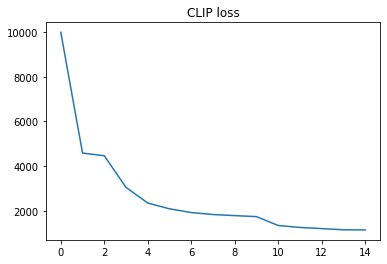

In [23]:
loss_img = torch.nn.CrossEntropyLoss()
loss_txt = torch.nn.CrossEntropyLoss()
params = list(text_encoder.parameters()) + list(image_encoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,10], gamma=0.1)

vocab_size = model.text_model.config.vocab_size
epochs = 15
totalbatches = int(len(dataset) / batchsize)
logit_scale = model.logit_scale.exp().item()
losses=[]
test_loss=[[rec1],[rec5],[rec10]]
for epoch in range(0, epochs):
    i = 0
    batch_loss = 0
    for batch in train_dataloader:
        if i % 2 == 0:
            print("epoch:", epoch, "batch:", i, "/", totalbatches, end='\r')
       
        optimizer.zero_grad()
        dense_images, tokenized_caps = batch
        
        with torch.no_grad():
            tokenized_caps['input_ids'] = tokenized_caps['input_ids'].squeeze()
            tokenized_caps['attention_mask'] = tokenized_caps['attention_mask'].squeeze()

            last_hidden_states = model.text_model(**tokenized_caps).last_hidden_state
            last_hidden_states = model.text_projection(last_hidden_states)
            input_ids = tokenized_caps['input_ids']
            attention_masks = tokenized_caps['attention_mask']
        
        # sparse encoding
        sparse_ims = image_encoder(dense_images)
        sparse_caps = text_encoder(last_hidden_states, input_ids, attention_masks)

        # determine logits
        sparse_ims = sparse_ims / sparse_ims.norm(dim=-1, keepdim=True)
        sparse_caps = sparse_caps / (sparse_caps + 1e-20).norm(dim=-1, keepdim=True)
        logits_per_image = logit_scale * sparse_ims @ sparse_caps.t()
        logits_per_text = logits_per_image.t()
        
        # compute losses
        ground_truth = torch.arange(len(dense_images),dtype=torch.long,device=device)
        
        loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
            
        batch_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        i+=1
        
    scheduler.step()
    losses.append(batch_loss)
    
    recall1,recall5,recall10 = test_sparse_performance(text_encoder, image_encoder, test_images, test_features, test_ids, test_masks)
    test_loss[0].append(recall1)
    test_loss[1].append(recall5)
    test_loss[2].append(recall10)

"""
    torch.save({
        'epoch':epoch,
        'model_state_dict': sparse_mlm.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"Models/" + str(epoch) + ".pt")
"""      
print("")
print("done")

plt.plot(losses)
plt.title('CLIP loss')
plt.show()

In [24]:
losses

[9991.704441137612,
 4588.213018421084,
 4465.333352152258,
 3050.003486884292,
 2351.5427540526725,
 2092.6645212465664,
 1925.3335622741142,
 1836.989862070419,
 1788.368946944829,
 1742.706851074472,
 1346.6107155780192,
 1259.7794984761276,
 1207.6969711557613,
 1155.1770082625444,
 1148.6103567448445]

In [17]:
losses

[6430.408537503332,
 4524.70970249176,
 4484.588026313111,
 3037.5475427880883,
 2354.8314702662174,
 2080.23203930445,
 1675.5190703687258,
 1616.2828402376035,
 1538.443697747629]

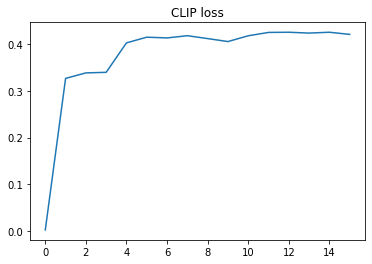

In [25]:
plt.plot(test_loss[0])
plt.title('CLIP loss')
plt.show()
# batch size:16

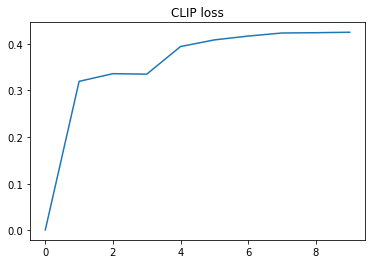

In [19]:
plt.plot(test_loss[0])
plt.title('CLIP loss')
plt.show()
# batch size:16

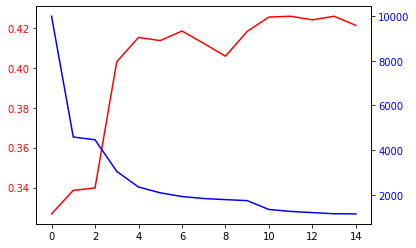

In [26]:
fig, ax = plt.subplots()

ax.plot(test_loss[0][1:], color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(losses, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.show()
# batch size:16

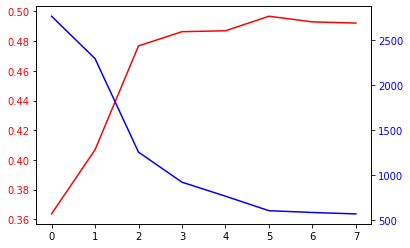

In [29]:
fig, ax = plt.subplots()

ax.plot(test_loss[0][2:], color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(losses[1:], color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.show()
# batch size:64

In [26]:
test_files[0]

'datasets/flickr30k/test/1007129816.jpg'

In [46]:
blocksize = 150
with torch.no_grad():
    regions = []
    image = Image.open(test_files[0])
    coords = torch.Tensor([0,0,0,0])
    for x in range(0, 440, blocksize):
        for y in range(0, 480, blocksize):
            left = y
            upper = x
            right = y + blocksize
            lower = x + blocksize
            coords = torch.vstack((coords, torch.Tensor([left,upper,right,lower])))
            regions.append(image.crop((left,upper,right,lower)))

    print(image)
    processed_image = preprocess(image, return_tensors='pt')['pixel_values'].to(device)
    print(processed_image.shape)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x461 at 0x22F4C3F2730>
torch.Size([1, 3, 224, 224])


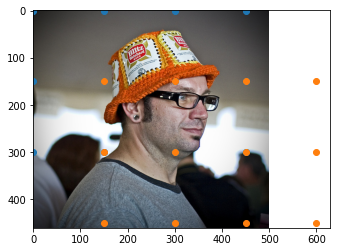

In [47]:
plt.imshow(image)
plt.scatter(coords[1:, 0], coords[1:, 1])
plt.scatter(coords[1:, 2], coords[1:, 3])

In [48]:
with torch.no_grad():
    test_ims = torch.Tensor().to(device)
    for region in regions:
        im = preprocess(region, return_tensors='pt')['pixel_values'].to(device)
        im = model.vision_model(im).pooler_output
        im = model.visual_projection(im)
        test_ims = torch.cat((test_ims, im), 0)

In [49]:
test_ims.shape

torch.Size([12, 512])

In [50]:
hat = []
head = []
glasses = []
orange = []
for test_im in test_ims:
    sparse_encoding = image_encoder(test_im)
    
    hat.append(sparse_encoding[3801].item())
    head.append(sparse_encoding[1375].item())
    glasses.append(sparse_encoding[6116].item())
    orange.append(sparse_encoding[4287].item())

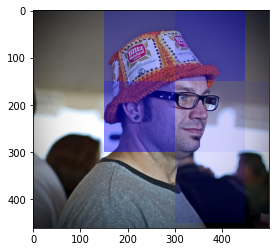

In [51]:
plt.imshow(image)

for i, coor in enumerate(coords[1:]):
    plt.axhspan(coor[1], coor[3], coor[0]/500, coor[2]/500, facecolor='blue', alpha=hat[i]/2)

plt.show()

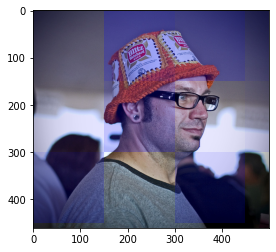

In [52]:
plt.imshow(image)

for i, coor in enumerate(coords[1:]):
    plt.axhspan(coor[1], coor[3], coor[0]/500, coor[2]/500, facecolor='blue', alpha=head[i]/2)

plt.show()

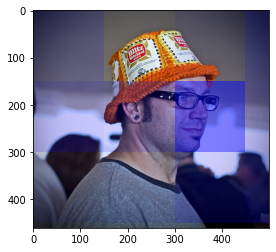

In [53]:
plt.imshow(image)

for i, coor in enumerate(coords[1:]):
    plt.axhspan(coor[1], coor[3], coor[0]/500, coor[2]/500, facecolor='blue', alpha=glasses[i]/2)

plt.show()

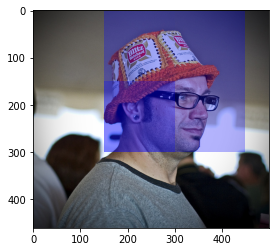

In [54]:
plt.imshow(image)

for i, coor in enumerate(coords[1:]):
    plt.axhspan(coor[1], coor[3], coor[0]/500, coor[2]/500, facecolor='blue', alpha=orange[i]/2)

plt.show()

In [96]:
print(list(vocab.keys())[list(vocab.values()).index(4287)])

orange</w>


In [25]:
for idx in torch.topk(sparse_encoding, 20).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], sparse_encoding[idx])

hat</w> tensor(0.8848, device='cuda:0', grad_fn=<SelectBackward0>)
head</w> tensor(0.6788, device='cuda:0', grad_fn=<SelectBackward0>)
<|startoftext|> tensor(0.6089, device='cuda:0', grad_fn=<SelectBackward0>)
glasses</w> tensor(0.6073, device='cuda:0', grad_fn=<SelectBackward0>)
man</w> tensor(0.5363, device='cuda:0', grad_fn=<SelectBackward0>)
guy</w> tensor(0.5222, device='cuda:0', grad_fn=<SelectBackward0>)
sunglasses</w> tensor(0.5038, device='cuda:0', grad_fn=<SelectBackward0>)
orange</w> tensor(0.4874, device='cuda:0', grad_fn=<SelectBackward0>)
cap</w> tensor(0.4868, device='cuda:0', grad_fn=<SelectBackward0>)
wears</w> tensor(0.4577, device='cuda:0', grad_fn=<SelectBackward0>)
gentlemen</w> tensor(0.4359, device='cuda:0', grad_fn=<SelectBackward0>)
cau tensor(0.4358, device='cuda:0', grad_fn=<SelectBackward0>)
gentleman</w> tensor(0.4247, device='cuda:0', grad_fn=<SelectBackward0>)
hats</w> tensor(0.4214, device='cuda:0', grad_fn=<SelectBackward0>)
happy</w> tensor(0.4059, dev

In [85]:
torch.topk(sparse_encoding, 20).indices[0:20]

tensor([ 3801,  1375, 49406,  6116,   786,  2149, 12906,  4287,  3938, 11869,
        11692,  1121, 13293,  9812,   900, 12123, 11444,  2568,  3889,  2801],
       device='cuda:0')

In [18]:
sparse_encoding = image_encoder(test_images[0])

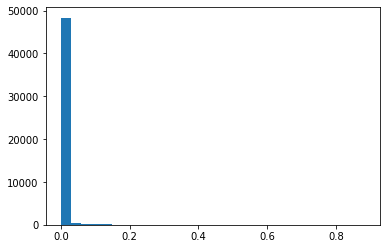

tensor(117.5411, device='cuda:0', grad_fn=<NormBackward1>)


In [19]:
plt.hist(sparse_encoding.cpu().detach().numpy(), bins=30)
plt.show()

l1_regularization = torch.norm(sparse_encoding, 1)
print(l1_regularization)

In [20]:
sparse_encoding.unique(return_counts=True)

(tensor([0.0000e+00, 9.6690e-43, 6.2358e-42,  ..., 6.0891e-01, 6.7876e-01,
         8.8476e-01], device='cuda:0', grad_fn=<Unique2Backward0>),
 tensor([47638,     1,     1,  ...,     1,     1,     1], device='cuda:0'))

In [21]:
(sparse_encoding > 0.3).unique(return_counts=True)

(tensor([False,  True], device='cuda:0'),
 tensor([49370,    38], device='cuda:0'))

In [22]:
#open the json file for annotations
f = open("C:/Users/Lalashops/Desktop/MasterThesis/random images/vocab.json", encoding = 'utf-8')
vocab = json.load(f)

In [53]:
test_files[0]

'datasets/flickr30k/test/1007129816.jpg'

In [ ]:
#test set:

In [26]:
#after training
rec1,rec5,rec10 = test_sparse_performance(text_encoder, image_encoder, test_images, test_features, test_ids, test_masks)

print(rec1)
print(rec5)
print(rec10)

tensor(0.4914)
tensor(0.7606)
tensor(0.8418)
